# $c_p$ DREAMING EXPERIMENTS

In [1205]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [918]:
# imports
import sys, os
sys.path.append('../../deep_dream_src/')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
from plot_utils import draw_smiles_linker, create_parity_plot
from nn_functions import featurize_df, prepare_hybrid_dataset, MolecularLSTMModel, prepare_dreaming_mof, prepare_dreaming_edge, split_dataframe
from utils import *
from tokenizer_functions import *
import selfies as sf
from group_selfies import GroupGrammar, bond_constraints
import math
import pickle 
group_constraints = {'H': 1, 'F': 1, 'Cl': 1, 'Br': 1, 'I': 1, 'B': 3, 'B+1': 2, 'B-1': 4, 'O': 2, 'O+1': 3, 'O-1': 1, 'N': 3, 'N+1': 4, 'N-1': 2, 'C': 4, 'C+1': 3, 'C-1': 3, 'P': 5, 'P+1': 6, 'P-1': 4, 'S': 6, 'S+1': 7, 'S-1': 5, '?': 8, '*': math.inf, 'Fr': 1}
bond_constraints.set_semantic_constraints(group_constraints)
from dreaming_functions import *
import rdkit
from rdkit import Chem
rdkit.RDLogger.DisableLog('rdApp.warning')

### Collect our input data

In [3]:
training_data = pd.read_csv('../../train_models/training_data.csv')
group_grammar = GroupGrammar.from_file('../gs_mof_grammar.txt')
training_data.head(1)

,edge_selfie,edge_canon_smile,edge_group_selfie,group_selfie_length,node_selfie,topo,SA_score,connection_point,MOFname,totalPOV_VF,...,GSA,henry_coefficient_CO2_300_mol_kg_Pa,log_henry_coefficient_CO2_300,heat_of_adsorption_CO2_300_kJ_mol,henry_coefficient_N2_300_mol_kg_Pa,log_henry_coefficient_N2_300,heat_of_adsorption_N2_300_kJ_mol,henry_CO2_N2_selectivity,log_CO2_N2_selectivity,filename
0,[O][O][C][=C][C][Branch1][C][Fr][C][Branch1][R...,OOC1=CC([Fr])C(OO)=CC1=C1NN([Fr])N1,[O][O][C][=C][C][Branch][C][=Branch][=C][C][Br...,28,[Fr][C][O][Cu][O][C][Branch1][C][Fr][O][Cu][Br...,acs,5.938156,"[11, 27]",acs_N125_edge1276,0.7545,...,4100.11,0.000005,-12.2,-10.097733,0.000002,-13.3,-4.43999,2.92,1.072161,acs_N125_edge1276.cif


In [4]:
target_names = ['cp']

mof_selfies_encoding, tokenized_info = featurize_df(
    training_data,
    target_names,
    edge_rep = 'edge_group_selfie',
    node_rep = 'node_selfie',
    topo_rep = 'topo'
    )

samples = 10000
split_by = {
    'method': 'sample',
    'train': samples,
    'validate': 1000,
    'test': 1000
    }

train_df, validate_df, test_df = split_dataframe(mof_selfies_encoding, split_by, seed=42)

../../deep_dream_src\nn_functions.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['tokenized_edge_selfies'] = tokenized_selfies
../../deep_dream_src\nn_functions.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['edge_lens'] = edge_lens
../../deep_dream_src\nn_functions.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [5]:
train_df.head(1)

,MOFname,edge_group_selfie,node_selfie,topo,cp,tokenized_edge_selfies,edge_lens,node_plus_topo,tokenized_node_plus_topo,node_plus_topo_lens,mof_string,tokenized_mof_string,mof_string_lens
0,sxb_N265_edge4527,[:0methyl_amine][Ring1][C][=C][Branch][C][Bran...,[Fr][C][O][Zn][O][C][Branch1][C][Fr][O][Zn][Br...,sxb,0.939584,"[16, 68, 61, 52, 60, 61, 60, 65, 52, 60, 64, 7...",31,[Fr][C][O][Zn][O][C][Branch1][C][Fr][O][Zn][Br...,"[34, 22, 48, 65, 48, 22, 20, 22, 34, 48, 65, 2...",56,[:0methyl_amine][Ring1][C][=C][Branch][C][Bran...,"[20, 110, 75, 58, 74, 75, 74, 101, 58, 74, 89,...",89


# Load Language Models

In [6]:
dream_name = f'LSTM_interval_noise_06_{target_names[0]}_11000samples_group_selfies'
predictor_name = f'LSTM_interval_noise_00_{target_names[0]}_11000samples_group_selfies'

with open('../../train_models/mof_saved_models/{}.pkl'.format(dream_name), 'rb') as f:
    dream_train_info = pickle.load(f)
scaler = dream_train_info['scaler']
tokenized_info = dream_train_info['tokenized_info']
dream_train_info['hyperparams']['num_layers'] = 1     # For some reason the model saved layers using a tuple
dream_hyperparams = dream_train_info['hyperparams']

with open('../../train_models/mof_saved_models/{}.pkl'.format(predictor_name), 'rb') as f:
    predictor_train_info = pickle.load(f)
predictor_train_info['hyperparams']['num_layers'] = 1     # For some reason the model saved layers using a tuple
predictor_hyperparams = predictor_train_info['hyperparams']
predictor_scaler = predictor_train_info['scaler']

c:\Users\x82753cc\AppData\Local\anaconda3\envs\deep_dreaming\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
dreaming_model = MolecularLSTMModel(**dream_hyperparams)
dreaming_model.load_state_dict(dream_train_info['model_state_dict'])
predictor_model = MolecularLSTMModel(**predictor_hyperparams)
predictor_model.load_state_dict(predictor_train_info['model_state_dict'])

<All keys matched successfully>

## Test model

(1000, 1)


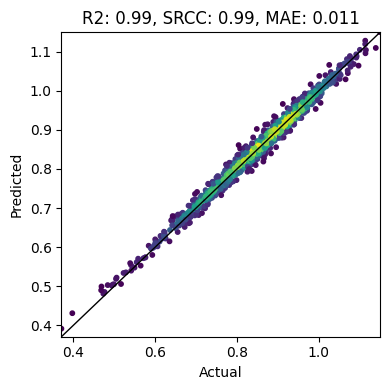

In [8]:
validate_loader, _ = prepare_hybrid_dataset(test_df,tokenized_info,target_names,pad_node=False,batch_size=1,shuffle=True,train=False,scaler=predictor_scaler,noise_level=predictor_train_info['noise_level'])
create_parity_plot(predictor_model, predictor_scaler, validate_loader)

# Dreaming 

#### Lets visualise the attention weights

In [9]:
scaled_seed_value = [0.2]
seed_value = predictor_scaler.inverse_transform(np.array(scaled_seed_value).reshape(1, -1))
idx = train_df[target_names[0]].sub(seed_value[0][0]).abs().idxmin()
seed_mof_string = train_df.iloc[idx]['mof_string']
train_df.iloc[idx]

MOFname                                                   unc_N164_edge171771
edge_group_selfie           [Br][:3pyridine][Ring2][C][=Branch][=C][Branch...
node_selfie                 [Fr][C][O][In][Branch1][Ring2][O][Ring1][Ring2...
topo                                                                      unc
cp                                                                   0.485487
tokenized_edge_selfies      [59, 41, 69, 61, 51, 52, 60, 61, 51, 52, 68, 6...
edge_lens                                                                  23
node_plus_topo              [Fr][C][O][In][Branch1][Ring2][O][Ring1][Ring2...
tokenized_node_plus_topo    [34, 22, 48, 39, 20, 55, 48, 54, 55, 20, 6, 48...
node_plus_topo_lens                                                        39
mof_string                  [Br][:3pyridine][Ring2][C][=Branch][=C][Branch...
tokenized_mof_string        [71, 45, 111, 75, 57, 58, 74, 75, 57, 58, 110,...
mof_string_lens                                                 

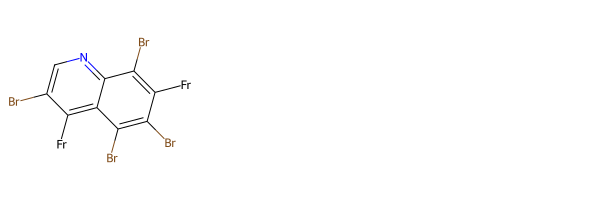

In [10]:
draw_smiles_linker([Chem.MolToSmiles(group_grammar.decoder(train_df.iloc[idx]['edge_group_selfie']))])

In [11]:
def plot_attention_weights_1d(attention_weights, tokens, title="Attention Weights", save_fig=False):
    # Plotting
    fig, ax = plt.subplots(figsize=(5.2, 4))
    colors = ['indianred' if token == '[:3pyridine]' else 'orange' if token == '[Br]' else 'steelblue' for token in tokens]
    ax.bar(range(len(attention_weights)), attention_weights, tick_label=tokens, alpha=0.75, color=colors)
    ax.set_xticklabels(tokens, rotation=90)  # Set xticks rotation to 90 degrees
    ax.set_ylabel("Attention Weight")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    if save_fig:
        plt.savefig('figure.png', dpi=300)
    plt.show()

torch.Size([1, 39, 73])


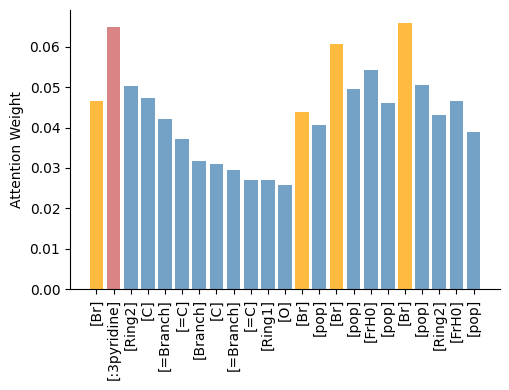

In [15]:
from dreaming_functions import predict_kpi
predicted_targets, attn_w1, attn_w2 = predict_kpi(predictor_model,seed_mof_string,tokenized_info)
edge_gs = seed_mof_string.split('[.]')[0]
len_edge_selfies = sf.len_selfies(edge_gs)
attn_edge = attn_w1.detach().numpy().flatten()[:len_edge_selfies] / np.sum(attn_w1.detach().numpy().flatten()[:len_edge_selfies])
plot_attention_weights_1d(attn_edge, list(sf.split_selfies(edge_gs)), title="Node Attention Weights", save_fig=True)

#### Lets perform a dreaming operation

In [1184]:
idx = 4517
seed_mof_string = train_df.iloc[idx]['mof_string']
train_df.iloc[idx]

MOFname                                                   lvt_N417_edge213319
edge_group_selfie           [O][:0pyridine][Ring1][C][=N][C][Branch][N][Br...
node_selfie                 [Fr][C][O][Cd][Cd][Branch1][=Branch2][O][C][Br...
topo                                                                      lvt
cp                                                                   0.747862
tokenized_edge_selfies      [66, 20, 68, 61, 53, 61, 60, 65, 60, 61, 60, 6...
edge_lens                                                                  23
node_plus_topo              [Fr][C][O][Cd][Cd][Branch1][=Branch2][O][C][Br...
tokenized_node_plus_topo    [34, 22, 48, 23, 23, 20, 6, 48, 22, 20, 22, 34...
node_plus_topo_lens                                                        40
mof_string                  [O][:0pyridine][Ring1][C][=N][C][Branch][N][Br...
tokenized_mof_string        [104, 24, 110, 75, 59, 75, 74, 101, 74, 75, 74...
mof_string_lens                                                 

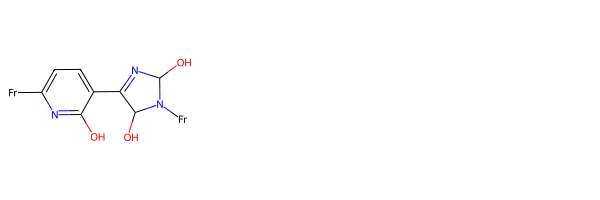

In [1183]:
draw_smiles_linker([Chem.MolToSmiles(group_grammar.decoder(train_df.iloc[idx]['edge_group_selfie']))])

In [1195]:
dream_settings = {
    'num_epochs': 1000,
    'lr': 0.001,
    'penalty_per_connection': 0.1,
    'SA_penalty_scaler': 0.1, # redundant
    'patience': 100,
    'noise_level': dream_train_info['noise_level'],
    'target_tolerance': 0.1,
    'constrain_sc': True,
    }

target_values = [0] # Note: the target here is the *scaled" target value, where 0 represents the lowest value in our traiing set and 1 the highest

valid_opt_pathway, transmutation_pathway, dreaming_losses = dream(
    dreaming_model,
    predictor_model,
    seed_mof_string,
    target_values,
    tokenized_info,
    group_grammar, 
    dream_settings,
    seed=12
    )

Restored variables from c:\Users\x82753cc\OneDrive - The University of Manchester\github_repositories\SARKISOV_GROUP_REPOs\dreaming4MOFs\deep_dream_src\scscore_1024uint8_model.ckpt-10654.as_numpy.json.gz
seed value: [0.50407356] | target value: [0.] | opt_flag: ['min']


opt flag: min, all targets: [0.45656896], valid linker, valid distance point
opt flag: min, all targets: [0.389374], valid linker, valid distance point
opt flag: min, all targets: [0.30835223], valid linker, valid distance point
opt flag: min, all targets: [0.24733359], valid linker, valid distance point
opt flag: min, all targets: [0.22036572], valid linker, valid distance point
opt flag: min, all targets: [0.20221394], valid linker, valid distance point
opt flag: min, all targets: [0.19062419], valid linker, valid distance point
Finished Training


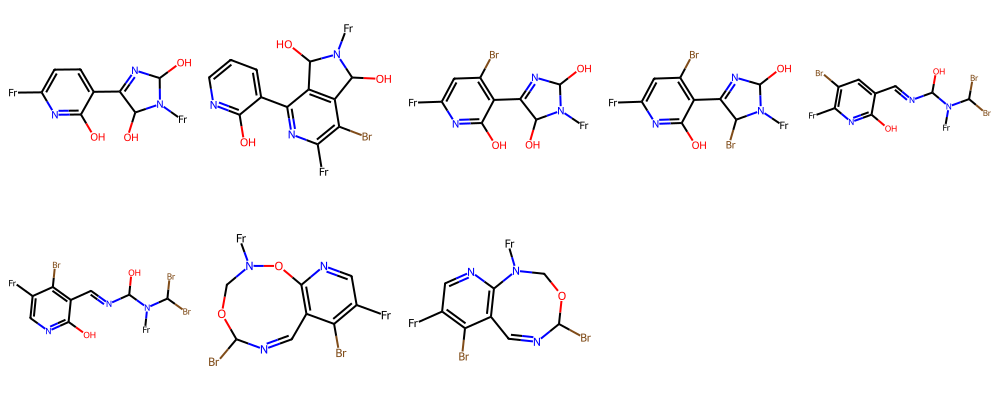

In [1196]:
draw_smiles_linker(valid_opt_pathway['dreamed_smiles'],molsPerRow=5,subImgSize=(200, 200),line_width=2)

# Automatic interpretation

Here we will show how to visualise and automatically interpret the transmutation pathways obtained from the deep dreaming model

In [1219]:
from analyse_opt_pathway import analyse_transmutation_pathway, plot_valid_transmutation_pathway

In [1197]:
target_values = [0]
dream_settings = {
    'num_epochs': 1000,
    'lr': 0.001,
    'penalty_per_connection': 0.1,
    'SA_penalty_scaler': 0.1, # redundant
    'patience': 100,
    'noise_level': dream_train_info['noise_level'],
    'target_tolerance': 0.1,
    'constrain_sc': True
    }

valid_pathways, trans_pathways = [], []
for seed in [12,31,49]:
    valid_opt_pathway, transmutation_pathway, dreaming_losses = dream(
        dreaming_model,
        predictor_model,
        seed_mof_string,
        target_values,
        tokenized_info,
        group_grammar, 
        dream_settings,
        seed=seed
        )
    valid_pathways.append(valid_opt_pathway)
    trans_pathways.append(transmutation_pathway)
#12 (min)
#16/17 or 18? (max),  25, 32

Restored variables from c:\Users\x82753cc\OneDrive - The University of Manchester\github_repositories\SARKISOV_GROUP_REPOs\dreaming4MOFs\deep_dream_src\scscore_1024uint8_model.ckpt-10654.as_numpy.json.gz
seed value: [0.50407356] | target value: [0.] | opt_flag: ['min']




c:\Users\x82753cc\AppData\Local\anaconda3\envs\deep_dreaming\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


opt flag: min, all targets: [0.45656896], valid linker, valid distance point
opt flag: min, all targets: [0.389374], valid linker, valid distance point
opt flag: min, all targets: [0.30835223], valid linker, valid distance point
opt flag: min, all targets: [0.24733359], valid linker, valid distance point
opt flag: min, all targets: [0.22036572], valid linker, valid distance point
opt flag: min, all targets: [0.20221394], valid linker, valid distance point
opt flag: min, all targets: [0.19062419], valid linker, valid distance point
Finished Training
Restored variables from c:\Users\x82753cc\OneDrive - The University of Manchester\github_repositories\SARKISOV_GROUP_REPOs\dreaming4MOFs\deep_dream_src\scscore_1024uint8_model.ckpt-10654.as_numpy.json.gz
seed value: [0.49443638] | target value: [0.] | opt_flag: ['min']


opt flag: min, all targets: [0.51254284], valid linker, valid distance point
opt flag: min, all targets: [0.4633403], valid linker, valid distance point
opt flag: min, all t

In each of the optimisations above, we have initialised the seed linker with different noise to obtain different transmutation trajectories. We can visualise these pathways and automatically interpret the importance of different tokens utilised by the model to traverse from one valid linker transmutation to the next using some built-in functionalities. First, let us use the `analyse_transmutation_pathway` function to analyse the token modifications, changes in the attention weights, changes in the SMILES strings, and changes in the properties of the linker, from one transmutation to the next.

In [1216]:
results = analyse_transmutation_pathway(
    trans_pathways[0],
    valid_pathways[0],
    seed_mof_string,
    predictor_model,
    tokenized_info
)


In [1200]:
results.head(1)

,transmutation,selfies_changes,token_substitutions,token_additions,token_removals,token_changes,attn_changes,smiles_changes,property_changes,property_diff,previous_formula,new_formula,composition_change,added_bonds,removed_bonds,tanimoto_similarity,connection_point_graph_distance,valid_transmutation
0,1,[O][:0pyridine][Ring1][C][=N][C][Branch][N][Br...,[[C]->[:4pyridine]],[],[],"[[[O], [:0pyridine], [Ring1], [C], [=N], [C], ...","[[0.035089206, 0.043830257, 0.04490938, 0.0444...",Oc1nc([Fr])ccc1C1=NC(O)N([Fr])C1O->Oc1ncccc1-c...,"{'MolecularWeight': '689.222->639.162', 'NumRi...","{'MolecularWeight': 50.059999999999945, 'NumRi...","{'O': 3, 'C': 8, 'N': 3, 'Fr': 2}","{'O': 3, 'C': 12, 'N': 3, 'Fr': 2}",C8H7Fr2N3O3->C12H9Fr2N3O3,"{(13, 14), (13, 7), (6, 1), (18, 19), (14, 16)...","{(14, 8), (10, 11), (7, 1), (10, 12), (3, 5), ...",0.372549,1.0-> 0.75,0


Next, we will pass these results to the `plot_valid_transmutation_pathway` function to automatically identify the valid linker transmutations, compute the attention score distributions between these valid transmutations and their statistics, and finally provide the appropriate visualisation.

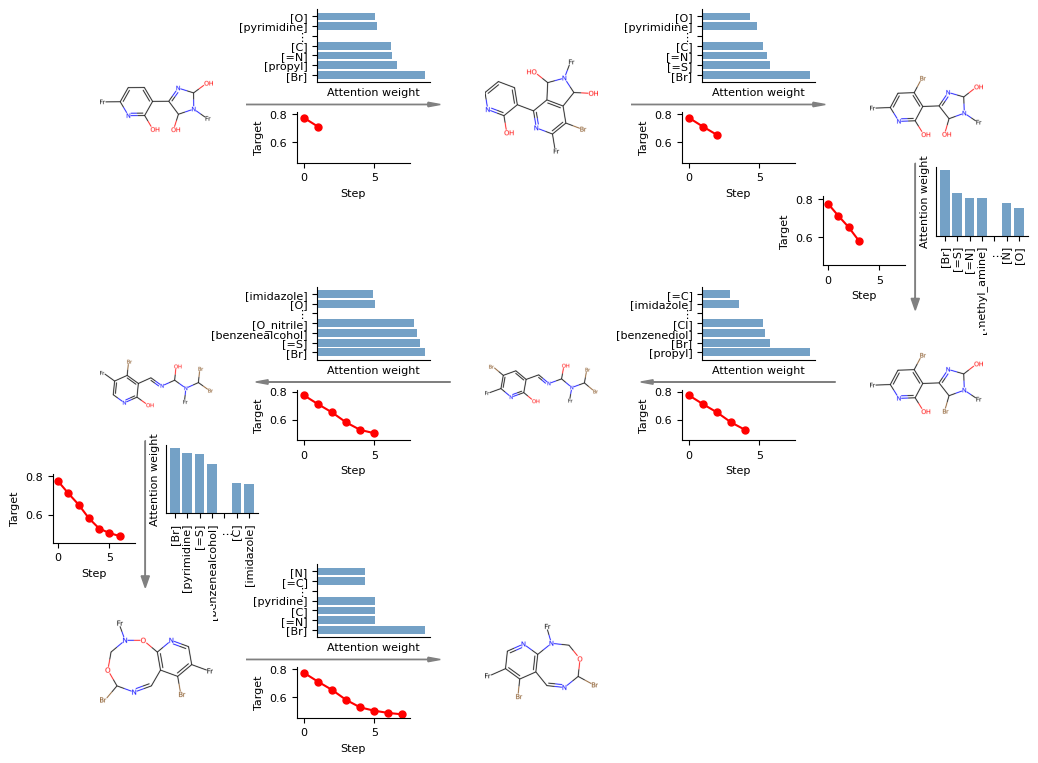

In [1220]:
plot_valid_transmutation_pathway(
    trans_pathways[0],
    valid_pathways[0],
    seed_mof_string, 
    predictor_model, 
    predictor_scaler,
    tokenized_info,
    target_log = False, 
    width=3
)

Let's do this for all of the pathways

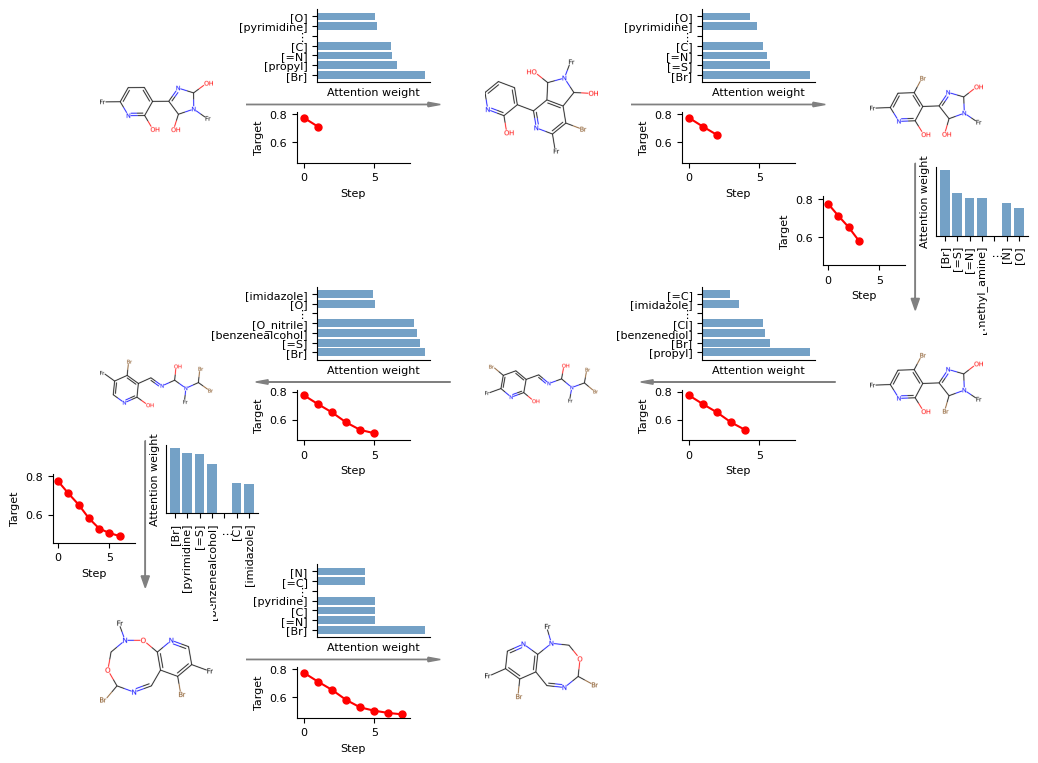

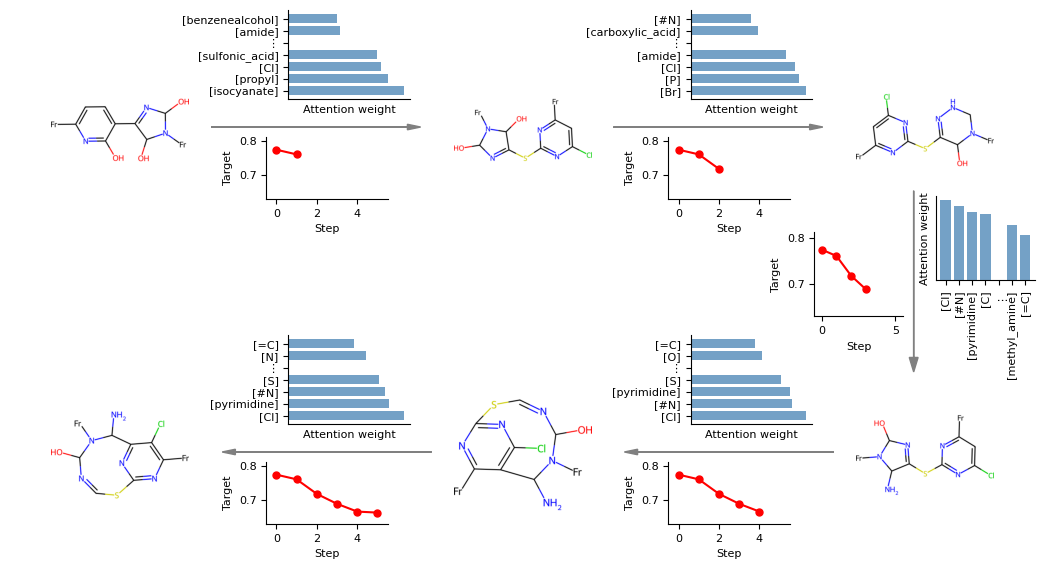

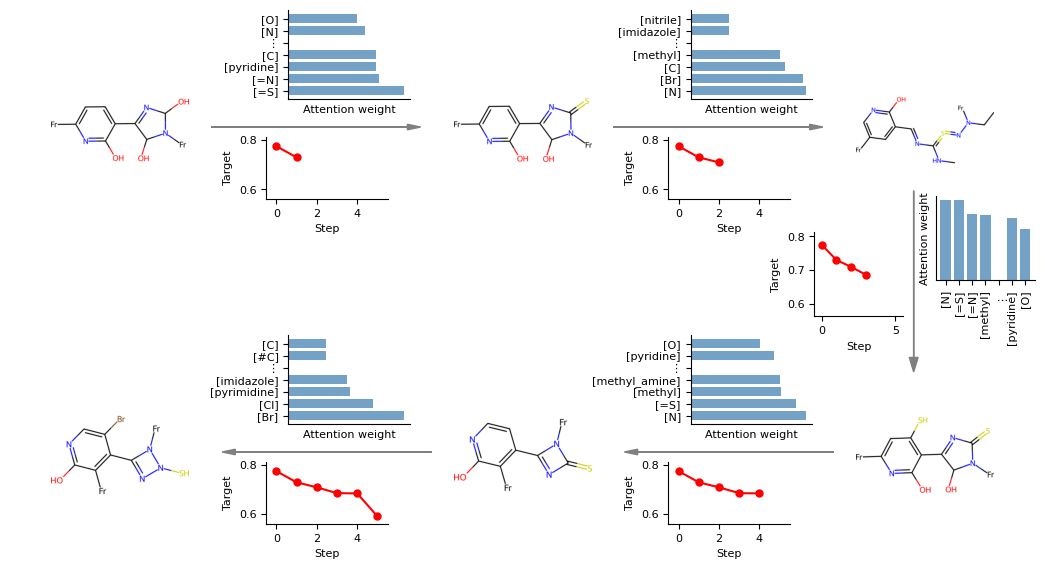

In [1203]:
for i in range(len(valid_pathways)):
    results = analyse_transmutation_pathway(
        trans_pathways[i],
        valid_pathways[i],
        seed_mof_string,
        predictor_model,
        tokenized_info
    )
    plot_valid_transmutation_pathway(
        trans_pathways[i],
        valid_pathways[i],
        seed_mof_string, 
        predictor_model, 
        predictor_scaler,
        tokenized_info,
        target_log = False, 
        width=3
    )


We can also get some statistics on the token manipulations for a given trajectory by providing the dataframe returned from the `analyse_transmutation_pathway` function 

In [1230]:
from analyse_opt_pathway import compute_statistics

compute_statistics(results)


{'total_substitutions': 663,
 'total_additions': 74,
 'total_removals': 66,
 'average_substitutions_per_mutation': 3.7885714285714287,
 'average_additions_per_mutation': 0.4228571428571429,
 'average_removals_per_mutation': 0.37714285714285717,
 'most_common_additions': {'[:0carboxylic_acid]': 15,
  '[=Ring1]': 12,
  '[=S]': 11,
  '[:1benzenediol]': 7,
  '[:0pyrimidine]': 5},
 'most_common_removals': {'[:0carboxylic_acid]': 14,
  '[=Ring1]': 11,
  '[:1benzenediol]': 6,
  '[=S]': 3,
  '[#Branch]': 3},
 'most_common_substitutions': {'[pop]->[Br]': 10,
  '[:0alkene]->[=N]': 9,
  '[=S]->[=Ring1]': 9,
  '[=N]->[:0alkene]': 8,
  '[=S]->[=N]': 8}}

# Shifted property distributions

In [ ]:
# ******************* EXAMPLE CELL TO OPTIMISE CP DISTRIBUTION *******************

# Seed distribution
cp_seed = pd.read_csv(('../seeds/cp_1000_seed_df.csv'))
target_values = [0]     # cp_min

# Dream settings
dream_settings = {
    'num_epochs': 1000,
    'lr': 0.001,
    'penalty_per_connection': 0.1,
    'SA_penalty_scaler': 0.1,
    'patience': 100,
    'noise_level': dream_train_info['noise_level'],
    'target_tolerance': 0.1
    }

# Perform dreaming for a distribution of cp MOFs
dream_results = []
exceptions = []
start, stop = 0, 10
count = 0
for i in range(start,stop): #range(len(encoding_df)): 
    print(i)
    try:
        global_opt_pathways = []
        for j in range(10): 
            seed_mof_string = cp_seed.iloc[i]['mof_string']
            opt_mof_string = seed_mof_string
            local_valid_opt_pathway = run_dream_exp(
                dreaming_model, 
                predictor_model, 
                opt_mof_string, 
                target_values, 
                tokenized_info, 
                group_grammar, 
                dream_settings,
                iterations=5
                )
            global_opt_pathways.append(local_valid_opt_pathway)
        
        # extract the pathway with the best target value (ensemble of local optimisations)
        if target_values[0] <= 0:
            valid_opt_pathway = global_opt_pathways[np.argmin([pathway.iloc[-1]['predictor_targets'][0] for pathway in global_opt_pathways])]
        elif target_values[0] >= 1:
            valid_opt_pathway = global_opt_pathways[np.argmax([pathway.iloc[-1]['predictor_targets'][0] for pathway in global_opt_pathways])]
        else:
            raise ValueError('Target value must be <= 0 or >= 1')

        # store results in new dataframe
        dream_results.append({
            'seed_mof_name': cp_seed.iloc[i]['MOFname'],
            'seed_mof_string': seed_mof_string,
            'seed_edge_selfies': cp_seed.iloc[i]['edge_group_selfie'],
            'seed_target': cp_seed.iloc[i][target_names[0]],
            'dreamed_mof_string': valid_opt_pathway.iloc[-1]['dreamed_mof_string'],
            'dreamed_edge_selfies': valid_opt_pathway.iloc[-1]['dreamed_selfies'],
            'dreamed_edge_smiles': valid_opt_pathway.iloc[-1]['dreamed_smiles'],
            'dreamed_target': scaler.inverse_transform(np.array(valid_opt_pathway.iloc[-1]['predictor_targets'][0]).reshape(1, -1)).item(),
        })
        count += 1
        if count % 5 == 0:
            dream_results_df = pd.DataFrame(dream_results)
            dream_results_df.to_csv(f'./dream_results/{start}_{stop}_{target_names[0]}_dream_results_TEST.csv')    	
    except Exception as e:
        exceptions.append(e)
        continue
dream_results_df = pd.DataFrame(dream_results)
dream_results_df.to_csv(f'./dream_results/{start}_{stop}_{target_names[0]}_dream_results_TEST.csv')

#### Let's visualise the dreaming results

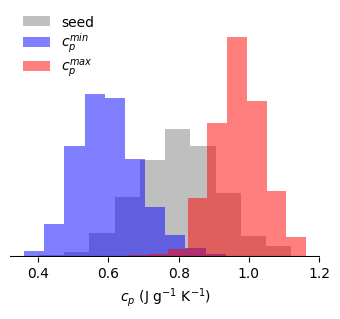

In [ ]:
# Visualise the results for 1000 MOFs
# Note: these are the results obtained after reconstructing MOFs from their strings and running the ML model of Moosavi et al. to determine the high-fidelity properties
min_results = pd.read_csv('./dream_results/cp_min_1000_dream_results.csv')
max_results = pd.read_csv('./dream_results/cp_max_1000_dream_results.csv')

fig,ax=plt.subplots(1,1,figsize=(4,3))
ax.hist(max_results['seed_target'], bins=10,color='grey',alpha=0.5,density=True,label='seed')
ax.hist(min_results['dreamed_target'],bins=10,alpha=0.5,density=True,label='$c_p^{min}$',color='blue')
ax.hist(max_results['dreamed_target'],bins=10,alpha=0.5,density=True,label='$c_p^{max}$',color='red')
ax.set_xlabel('$c_p$ ($\mathregular{J\ g^{-1}\ K^{-1}}$)')
plt.box(False)
ax.tick_params(left=False, labelleft=False)
ax.axhline(y=0, color='black', linestyle='-')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(0, 1.1),labelspacing=0.15)
fig.savefig('cp_hist.png',dpi=500,bbox_inches="tight")

#### tSNE projection of 10,000 dreamed MOFs

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from utils import compute_fingerprints

max_results = pd.read_csv(f'./dream_results/cp_max_10000_dream_results.csv',index_col=[0])
min_results = pd.read_csv(f'./dream_results/cp_min_10000_dream_results.csv',index_col=[0])

# Generate fingerprints
max_generated_fps = compute_fingerprints(max_results['dreamed_edge_smiles'].tolist())
min_generated_fps = compute_fingerprints(min_results['dreamed_edge_smiles'].tolist())
reference_fps = compute_fingerprints(training_data['edge_canon_smile'].tolist())

# Combine fingerprints
all_fps = np.array(max_generated_fps + min_generated_fps + reference_fps)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=200, learning_rate=50, random_state=42)
reduced_data = tsne.fit_transform(all_fps)

# Split the transformed data for plotting
max_transformed_generated = reduced_data[:len(max_generated_fps), :]
min_transformed_generated = reduced_data[len(max_generated_fps):len(max_generated_fps)+len(min_generated_fps), :]
transformed_reference = reduced_data[len(max_generated_fps)+len(min_generated_fps):, :]

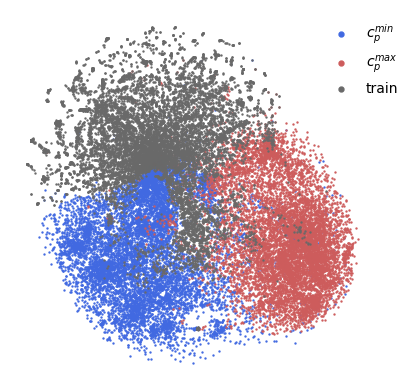

In [20]:
fig,ax=plt.subplots(1,1,figsize=(4.2,4))
ax.scatter(min_transformed_generated[:, 0], min_transformed_generated[:, 1], color='royalblue',s=.5,label='$c_p^{min}$',alpha=1)
ax.scatter(max_transformed_generated[:, 0], max_transformed_generated[:, 1], color='indianred',s=.5,label='$c_p^{max}$',alpha=1)
ax.scatter(transformed_reference[:, 0], transformed_reference[:, 1], color='dimgrey',s=.5,label='train',alpha=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.legend(bbox_to_anchor=(1.1, 1), loc='upper right', markerscale=5,frameon=False)
ax.tick_params(left=False, labelleft=False)
ax.tick_params(bottom=False, labelbottom=False)
plt.tight_layout()
plt.show()
fig.savefig('cp_tSNE.png',dpi=500,bbox_inches="tight")

#### Compute regression error as a function of the Tanimoto similarity 

In [ ]:
from utils import snn_metric
from dreaming_functions import predict_kpi

# get the high-fidelity data
min_results = pd.read_csv('./dream_results/cp_min_1000_dream_results.csv')
max_results = pd.read_csv('./dream_results/cp_max_1000_dream_results.csv')

# compute the SNN metrics
to_check = pd.concat([min_results,max_results])
snn, dist = snn_metric(to_check['dreamed_edge_smiles'].tolist(), training_data['edge_canon_smile'].tolist(), return_similarities=True)
to_check['max_similarity'] = dist

In [554]:
# get the predicted targets
predicted_targets = []
for iter, row in to_check.iterrows():
    mof_string = row['dreamed_mof_string']
    predicted_target, _, _ = predict_kpi(predictor_model,mof_string,tokenized_info)
    predicted_targets.append(predictor_scaler.inverse_transform(np.array(predicted_target.detach()).reshape(1, -1)).item())
to_check['predicted_dreamed_target'] = predicted_targets

In [1239]:
from sklearn.metrics import mean_absolute_error
# Define the tanimoto bins
bins = np.arange(0, 1.1, 0.1)

# Create a new column 'similarity_bin' with the bin labels and group the data
to_check['similarity_bin'] = pd.cut(to_check['max_similarity'], bins=bins, include_lowest=True)
grouped = to_check.groupby('similarity_bin')

maes = []
for name, group in grouped:
    try:
        maes.append(mean_absolute_error(group['dreamed_target'],group['predicted_dreamed_target']))
    except:
        maes.append(0)
        print('group empty')

group empty
group empty


C:\Users\x82753cc\AppData\Local\Temp\ipykernel_28720\4183908458.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = to_check.groupby('similarity_bin')


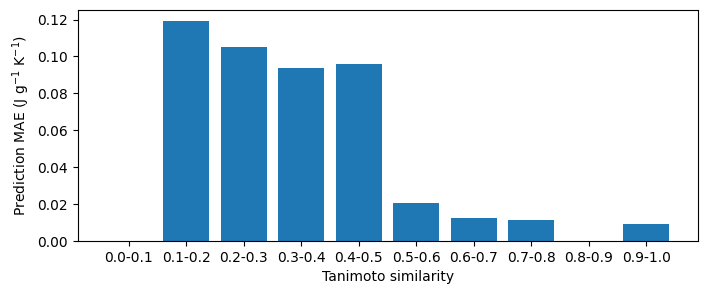

In [1241]:
bins = np.arange(0, 1.1, 0.1)
plt.figure(figsize=(8, 3))
plt.bar(range(len(maes)), maes, tick_label=[f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(len(bins)-1)])
plt.xlabel('Tanimoto similarity')
plt.ylabel('Prediction MAE ($\mathregular{J\ g^{-1}\ K^{-1}}$)')
plt.show()

#### Computing the uncertainty in the model predictions

Now, lets compare this regression error with the unertainty of the deep dreaming model based on an ensemble of 10 models trained on different samples of the training dataset

In [1249]:
from dreaming_functions import prediction_with_uncertainty

In [1250]:
errors = []
dir_ensemble = '../../train_models/mof_saved_models/cp_ensemble'
# dir_ensemble = os.path.abspath(r'C:\Users\x82753cc\OneDrive - The University of Manchester\github_repositories\SARKISOV_GROUP_REPOs\dreaming4MOFs\train_models\mof_saved_models\cp_ensemble')
for iter, row in to_check.iterrows():
    mof_string = row['dreamed_mof_string']
    target_mean, error = prediction_with_uncertainty(dir_ensemble,mof_string,tokenized_info)
    errors.append(error)
to_check['variance'] = errors

In [1253]:
# Define the bins
bins = np.arange(0, 1.1, 0.1)

# Create a new column 'similarity_bin' with the bin labels and group
to_check['similarity_bin'] = pd.cut(to_check['max_similarity'], bins=bins, include_lowest=True)
grouped = to_check.groupby('similarity_bin')

mean_variances = []
for name, group in grouped:
    try:
        # print(np.mean(group['variance']))
        mean_variances.append(np.mean(group['variance']))
    except:
        mean_variances.append(0)
        print('group empty')

C:\Users\x82753cc\AppData\Local\Temp\ipykernel_28720\2267728271.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = to_check.groupby('similarity_bin')


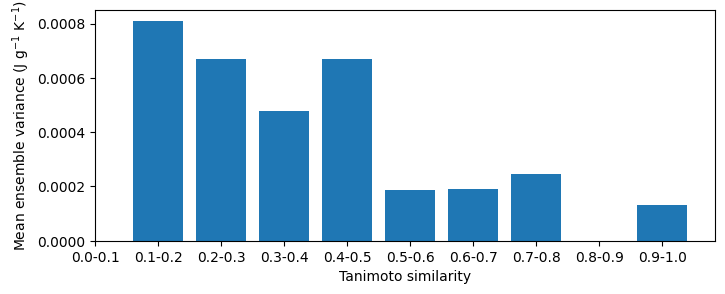

In [1255]:
bins = np.arange(0, 1.1, 0.1)

# Create the bar plot
plt.figure(figsize=(8, 3))
plt.bar(range(len(mean_variances)), mean_variances, tick_label=[f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(len(bins)-1)])
plt.xlabel('Tanimoto similarity')
plt.ylabel('Mean ensemble variance ($\mathregular{J\ g^{-1}\ K^{-1}}$)')
# plt.title('Mean Absolute Error by Similarity Bin')
plt.show()

# SA score vs SC score distributions for $c_p^{max}$ optimisation

In [106]:
def gs_to_canon_smiles(gs: str, grammar) -> str:
    smi = Chem.MolToSmiles(grammar.decoder(gs))
    # canonicalize smiles
    return Chem.MolToSmiles(Chem.MolFromSmiles(smi))

In [107]:
from kpi_small_mols import SAscore_from_smiles
scscorer = SCScorer()
scscorer.restore(os.path.abspath('../../deep_dream_src/scscore_1024uint8_model.ckpt-10654.as_numpy.json.gz'))

# SA scores
cp_max_SA_scores = SAscore_from_smiles(max_results['dreamed_edge_smiles'].tolist())
seed_smiles = [gs_to_canon_smiles(gs, group_grammar) for gs in max_results['seed_edge_selfies']]
seed_SA_scores = SAscore_from_smiles(seed_smiles)

# SC scores
seed_sc_scores, cp_max_sc_scores = [], []
for iter, row in max_results.iterrows():
    (smi_conv, sco) = scscorer.get_score_from_smi(gs_to_canon_smiles(row['seed_edge_selfies'],group_grammar))
    seed_sc_scores.append(sco)
    (smi_conv, sco) = scscorer.get_score_from_smi(row['dreamed_edge_smiles'])
    cp_max_sc_scores.append(sco)

Restored variables from c:\Users\x82753cc\OneDrive - The University of Manchester\github_repositories\SARKISOV_GROUP_REPOs\dreaming4MOFs\deep_dream_src\scscore_1024uint8_model.ckpt-10654.as_numpy.json.gz


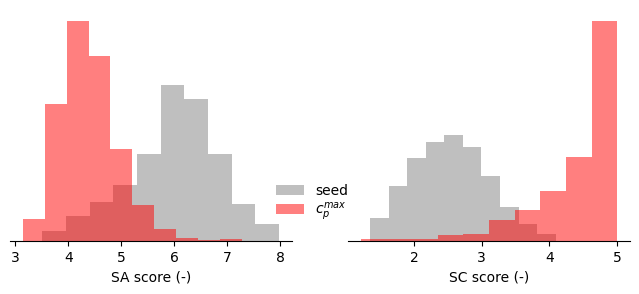

In [108]:
fig,ax=plt.subplots(1,2,figsize=(8,3))

ax[0].hist(seed_SA_scores, bins=10, color='grey', alpha=0.5, density=True, label='seed') 
ax[0].hist(cp_max_SA_scores, bins=10, alpha=0.5, density=True, label='$c_p^{max}$', color='red')
ax[0].set_xlabel('SA score (-)')
ax[0].tick_params(left=False, labelleft=False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].legend(frameon=False, loc='upper left', bbox_to_anchor=(0.9, 0.3), labelspacing=0.15)

ax[1].hist(seed_sc_scores, bins=10, color='grey', alpha=0.5, density=True, label='seed')
ax[1].hist(cp_max_sc_scores, bins=10, alpha=0.5, density=True, label='$c_p^{max}$', color='red')
ax[1].set_xlabel('SC score (-)')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].tick_params(left=False, labelleft=False)
fig.savefig('sa_vs_sc_score.png',dpi=500,bbox_inches="tight")

# Constrained vs unconstrained `SC_score` optimisation of $c_p^{max}$

Get `sc_scores` for mof linkers contained in the CoRE MOF database. Linker smiles strings obtained from [Moosavi et al.](https://www.nature.com/articles/s41467-020-17755-8)

In [109]:
import ast
core_df = pd.read_csv('./core_mof_data/core_mof_linkers.csv') 
core_df = core_df[core_df['RDKitLinkerSanity'] == True]
new_list = []
for s in core_df['linker-SMILES']:
    list_s = ast.literal_eval(s)
    for entry in list_s:
        try:
            new_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(entry)))
        except:
            continue

unique_core_linkers = list(set(new_list))
core_sc_scores = []
for smi in unique_core_linkers:
    (_, sco) = scscorer.get_score_from_smi(smi)
    core_sc_scores.append(sco)

[10:57:29] Can't kekulize mol.  Unkekulized atoms: 12 13 30 31 32 33 50 63
[10:57:29] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[10:57:29] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 32 33 34 35 36 37 38
[10:57:29] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 22 23 24 25 26 27 28
[10:57:29] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30 31 32 36 37
[10:57:29] Explicit valence for atom # 11 N, 4, is greater than permitted
[10:57:29] Can't kekulize mol.  Unkekulized atoms: 3 4 26 27 28 29 45 48
[10:57:29] Can't kekulize mol.  Unkekulized atoms: 2 3 10 11 12 13 26 46
[10:57:29] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[10:57:29] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[10:57:29] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[10:57:29] Can't kekulize mol.  Unkekulized atoms: 3 4 33 34 35 36 54 57
[10:57:29] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[10:57:29] Can't kekulize mol.  Unkekuliz

Get `sc_scores` from constrained and unconstrained `sc_score` optimisation of $c_p^{max}$ for 100 MOFs

In [1256]:
cp_max_100_unconstrained_dream_results = pd.read_csv('./dream_results/cp_max_100_unconstrained_dream_results.csv',index_col=[0])
cp_max_100_constrained_dream_results = pd.read_csv('./dream_results/cp_max_100_constrained_dream_results.csv')

In [117]:
seed_100_sc_scores, unconstrained_dreamed_sc_scores = [], []
for iter, row in cp_max_100_unconstrained_dream_results.iterrows():
    (smi_conv, sco) = scscorer.get_score_from_smi(Chem.MolToSmiles(group_grammar.decoder(row['seed_edge_selfies'])))
    seed_100_sc_scores.append(sco)
    (smi_conv, sco) = scscorer.get_score_from_smi(row['dreamed_edge_smiles'])
    unconstrained_dreamed_sc_scores.append(sco)

constrained_dreamed_sc_scores = []
for iter, row in cp_max_100_constrained_dream_results.iterrows():
    (smi_conv, sco) = scscorer.get_score_from_smi(row['dreamed_edge_smiles'])
    constrained_dreamed_sc_scores.append(sco)

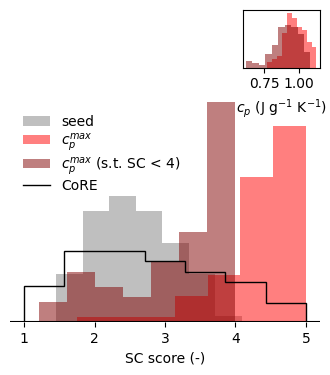

In [126]:
fig,ax= plt.subplots(figsize=(4,3))
ax.hist(seed_100_sc_scores,alpha=0.5,density=True,bins=7,color='grey',label='seed')
ax.hist(unconstrained_dreamed_sc_scores,alpha=0.5,bins=7,density=True,color='red',label='$c_p^{max}$')
ax.hist(constrained_dreamed_sc_scores,alpha=0.5,bins=7,density=True,color='maroon', label='$c_p^{max}$ (s.t. SC < 4)' )
h, edges = np.histogram(core_sc_scores, bins=7, density=True)
ax.stairs(h,edges,label='CoRE',color='black')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(0, 0.95),labelspacing=0.15)
plt.box(False)
ax.tick_params(left=False, labelleft=False)
ax.axhline(y=0, color='black', linestyle='-')
ax.set(xlabel='SC score (-)')

# Create a smaller subplot in the top left hand corner
ax1 = ax.inset_axes([0.75, 1.1, 0.25, 0.25])
ax1.set_yticklabels([])
ax1.tick_params(left=False)

# Plot the distribution of unconstrained_dreamed_targets
ax1.hist(cp_max_100_unconstrained_dream_results['dreamed_target'], bins=10, color='red',alpha=0.5,density=True)
ax1.hist(cp_max_100_constrained_dream_results['dreamed_target'], bins=10, color='maroon',alpha=0.5,density=True)
ax1.set_xlabel('$c_p$ ($\mathregular{J\ g^{-1}\ K^{-1}}$)')

# Show the plot
plt.show()
fig.savefig('constrained_sc_score.png',dpi=500,bbox_inches="tight")

Note, to run the constrained `sc_score` optimisation, we used the following settings:

```
target_values = [1]     

dream_settings = {
    'num_epochs': 5000,
    'lr': 0.001,
    'penalty_per_connection': 0.1,
    'patience': 100,
    'noise_level': dream_train_info['noise_level'],
    'target_tolerance': 0.1,
    'constrain_sc': True,
    }
```

# Comparing results before and after structural relaxation

To evaluate the impact that structural relaxation has on the predicted property values, we sampled a representative subset of 100 seed MOFs (and their $c_p^{max}$ / $c_p^{min}$ optimised counterparts) and relaxed their crystal structures using the UFF forcefield as implemented in the Forcite Module of Materials Studio 2019. The results are shown below

In [1263]:
# Note: these are the results obtained after reconstructing MOFs from their strings and running the ML model of Moosavi et al. to determine the high-fidelity properties
cp_max_relaxed = pd.read_csv('./dream_results/relaxed_vs_unrelaxed/cp_max_100_relaxed_dream_results.csv')
cp_max_unrelaxed = pd.read_csv('./dream_results/relaxed_vs_unrelaxed/cp_max_100_unrelaxed_dream_results.csv')
cp_min_relaxed = pd.read_csv('./dream_results/relaxed_vs_unrelaxed/cp_min_100_relaxed_dream_results.csv')
cp_min_unrelaxed = pd.read_csv('./dream_results/relaxed_vs_unrelaxed/cp_min_100_unrelaxed_dream_results.csv')

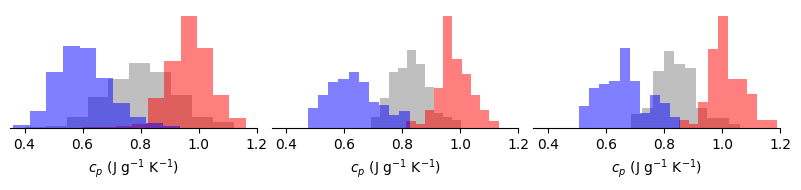

In [629]:
fig, ax = plt.subplots(1,3, figsize=(8, 2))

ax[0].hist(max_results['seed_target'], bins=10, color='grey', alpha=0.5, density=True, label='Original seed')
ax[0].hist(max_results['dreamed_target'], bins=10, color='red', alpha=0.5, density=True, label='Original dreamed')
ax[0].hist(min_results['dreamed_target'], bins=10, color='blue', alpha=0.5, density=True, label='Original dreamed')
# ax[0].set_title('Original Histograms')
ax[0].set_xlabel('$c_p$ ($\mathregular{J\ g^{-1}\ K^{-1}}$)')
ax[0].set_xlim(0.35,1.2)
# ax[0].legend(frameon=False)

ax[1].hist(cp_max_unrelaxed['seed_target'], bins=10, color='grey', alpha=0.5, density=True, label='Sampled seed')
ax[1].hist(cp_max_unrelaxed['dreamed_target'], bins=10, color='red', alpha=0.5, density=True, label='Sampled dreamed')
ax[1].hist(cp_min_unrelaxed['dreamed_target'], bins=10, color='blue', alpha=0.5, density=True, label='Sampled dreamed')
# ax[1].set_title('Sampled Histograms')
ax[1].set_xlabel('$c_p$ ($\mathregular{J\ g^{-1}\ K^{-1}}$)')
# ax[1].legend(frameon=False)
ax[1].set_xlim(0.35,1.2)

ax[2].hist(cp_max_relaxed['seed_target'], bins=10, color='grey', alpha=0.5, density=True, label='Original seed')
ax[2].hist(cp_max_relaxed['dreamed_target'], bins=10, color='red', alpha=0.5, density=True, label='Original dreamed')
ax[2].hist(cp_min_relaxed['dreamed_target'], bins=10, color='blue', alpha=0.5, density=True, label='Original dreamed')
# ax[2].set_title('Relaxed Histograms')
ax[2].set_xlabel('$c_p$ ($\mathregular{J\ g^{-1}\ K^{-1}}$)')
# ax[2].legend(frameon=False)
ax[2].set_xlim(0.35,1.2)

for a in ax:
    a.yaxis.set_ticks([])
    a.yaxis.set_ticklabels([])
    a.set_ylabel('')
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()
# plt.savefig('cp_relaxed_distributions.png',dpi=300,bbox_inches='tight')

Calculate the average percentage error for relaxed and unrelaxed KPIs

In [425]:
cp_max_relaxed['dreamed_mof_name'] = cp_max_relaxed['dreamed_mof_name'].str.replace('_opt', '')
cp_min_relaxed['dreamed_mof_name'] = cp_min_relaxed['dreamed_mof_name'].str.replace('_opt', '')

In [431]:
from sklearn.metrics import mean_absolute_error

merged_seed_df = pd.merge(cp_max_relaxed[['seed_mof_name','seed_target']], max_results[['seed_mof_name','seed_target']], on='seed_mof_name',suffixes=('_relaxed', '_unrelaxed'))
merged_max_df = pd.merge(cp_max_relaxed[['dreamed_mof_name','dreamed_target']], max_results[['dreamed_mof_name','dreamed_target']], on='dreamed_mof_name', suffixes=('_relaxed', '_unrelaxed'))
merged_min_df = pd.merge(cp_min_relaxed[['dreamed_mof_name','dreamed_target']], min_results[['dreamed_mof_name','dreamed_target']], on='dreamed_mof_name', suffixes=('_relaxed', '_unrelaxed'))

# calculcate MAE
print(
    mean_absolute_error(merged_seed_df['seed_target_relaxed'], merged_seed_df['seed_target_unrelaxed']),
    mean_absolute_error(merged_max_df['dreamed_target_relaxed'], merged_max_df['dreamed_target_unrelaxed']),
    mean_absolute_error(merged_min_df['dreamed_target_relaxed'], merged_min_df['dreamed_target_unrelaxed']),
)

# Calculate Percentage Error
print(
    (((merged_seed_df['seed_target_relaxed'] - merged_seed_df['seed_target_unrelaxed']).abs() / merged_seed_df['seed_target_relaxed']) * 100).mean(),
    (((merged_max_df['dreamed_target_relaxed'] - merged_max_df['dreamed_target_unrelaxed']).abs() / merged_max_df['dreamed_target_relaxed']) * 100).mean(),
    (((merged_min_df['dreamed_target_relaxed'] - merged_min_df['dreamed_target_unrelaxed']).abs() / merged_min_df['dreamed_target_relaxed']) * 100).mean(),
)


0.022253397789999997 0.03710270568 0.033274554450000014
2.585757036488892 3.631259343865387 5.041456993804154
